In [3]:
import os
import glob
import shutil
import random
from tqdm import tqdm

In [4]:
raw_data = r'/kaggle/input/mrl-eye-dataset'
for dirpath, dirname, filename in os.walk(raw_data):
    for file in tqdm([f for f in filename if f.endswith('.png')]):
        if file.split('_')[4] == '0':
            path=r'/kaggle/working/train/closed eyes'
            if not os.path.exists(path):
                os.makedirs(path)
            shutil.copy(src=dirpath + '/' + file, dst= path)
        elif file.split('_')[4] == '1':
            path=r'/kaggle/working/train/open eyes'
            if not os.path.exists(path):
                os.makedirs(path)
            shutil.copy(src=dirpath + '/' + file, dst= path)        

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 42952/42952 [05:46<00:00, 124.10it/s]


In [5]:
def create_test_closed(source, destination, percent):
    '''
    divides closed eyes images into given percent and moves from
    source to destination.
    
    Arguments:
    source(path): path of source directory
    destination(path): path of destination directory
    percent(float): percent of data to be divided(range: 0 to 1)
    '''
    path, dirs, files_closed = next(os.walk(source))
    file_count_closed = len(files_closed)
    percentage = file_count_closed * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')    

In [6]:
def create_test_open(source, destination, percent):
    '''
    divides open eyes images into given percent and moves from
    source to destination.
    
    Arguments:
    source(path): path of source directory
    destination(path): path of destination directory
    percent(float): percent of data to be divided(range: 0 to 1)
    '''
    path, dirs, files_open = next(os.walk(source))
    file_count_open = len(files_open)
    percentage = file_count_open * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')

In [7]:
create_test_closed(r'/kaggle/working/train/closed eyes', 
                    r'/kaggle/working/test/closed eyes', 
                    0.2)

moved 8389 images to the destination successfully.


In [8]:
create_test_open(r'/kaggle/working/train/open eyes', 
                    r'/kaggle/working/test/open eyes', 
                    0.2)

moved 8590 images to the destination successfully.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augumentation

In [10]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
batchsize=8

In [12]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data= train_datagen.flow_from_directory(r'/kaggle/working/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical',subset='training' )

validation_data= train_datagen.flow_from_directory(r'/kaggle/working/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical', subset='validation')

Found 54336 images belonging to 2 classes.
Found 13583 images belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'/kaggle/working/test',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical')

Found 16979 images belonging to 2 classes.


In [14]:
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
hmodel = bmodel.output
hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation= 'softmax')(hmodel)

model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normalization[0][0]']

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [17]:


earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[earlystop,learning_rate]

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
6792/6792 [==============================] - 511s 75ms/step - loss: 0.2053 - accuracy: 0.9201 - val_loss: 0.2437 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 2/20
6792/6792 [==============================] - 571s 84ms/step - loss: 0.1810 - accuracy: 0.9309 - val_loss: 0.2517 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 3/20
6792/6792 [==============================] - 510s 75ms/step - loss: 0.1680 - accuracy: 0.9354 - val_loss: 0.2517 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 4/20
6792/6792 [==============================] - 519s 76ms/step - loss: 0.1656 - accuracy: 0.9348 - val_loss: 0.2412 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 5/20
6792/6792 [==============================] - 556s 82ms/step - loss: 0.1606 - accuracy: 0.9374 - val_loss: 0.2631 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 6/20
6792/6792 [==============================] - 524s 77ms/step - loss: 0.1592 - accuracy: 0.9387 - val_loss: 0.2572 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 7/20
6792/6792 [==================

In [19]:
acc_tr, loss_tr = model.evaluate_generator(train_data)
print(acc_tr)
print(loss_tr)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.12286439538002014
0.9530329704284668


1698/1698 [==============================] - 106s 62ms/step - loss: 0.2302 - accuracy: 0.9144
Accuracy: 0.5026871825075462
Validation accuracy: 0.91437828540802


NameError: name 'classes' is not defined

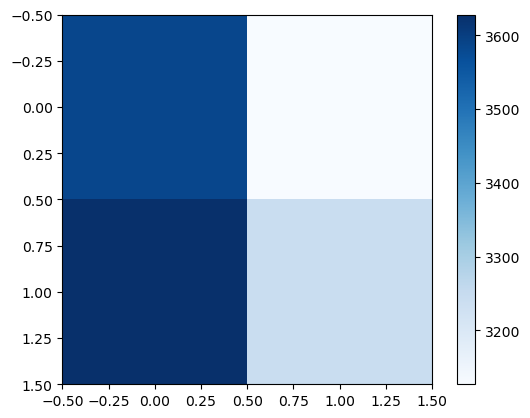

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# Load the model
model = load_model('/kaggle/working/model.h5')

# Make predictions on the validation data
y_pred = model.predict(validation_data)

# Get the predicted class for each sample
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each sample
y_true = validation_data.classes

# Calculate accuracy and validation accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
validation_accuracy = model.evaluate(validation_data)[1]

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Validation accuracy: {validation_accuracy}")

# Draw the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [21]:
model.save('/kaggle/working/model.h5')

In [25]:
import matplotlib.pyplot as plt

history= model.evaluate_generator(train_data)

# Plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'list' object has no attribute 'history'

In [ ]:
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('/path/to/model.h5')

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)

# Plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1698/1698 [==============================] - 101s 60ms/step


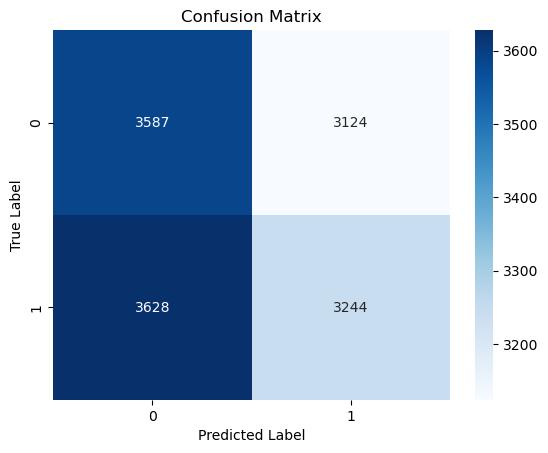

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation data
y_pred = model.predict(validation_data)

# Get the predicted class for each sample
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each sample
y_true = validation_data.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
